# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

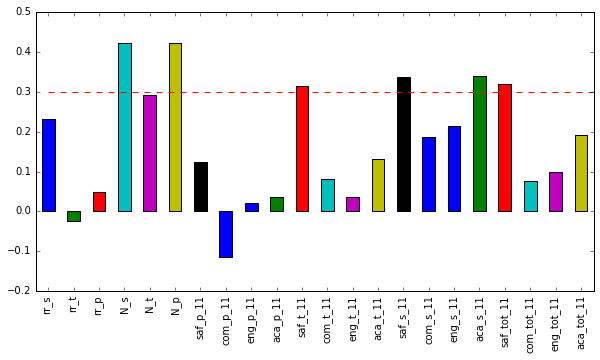

In [12]:
correlations[survey_fields].plot.bar(rot = 90, figsize = (10,5))
plt.hlines(y = 0.3, xmin = 0, xmax = 22, colors = 'red', linestyle = '--')
plt.show()

**[dictionary]**
* `rr_s`	Student Response Rate
* `rr_t`	Teacher Response Rate
* `rr_p`	Parent Response Rate
* `N_s`	Number of student respondents
* `N_t`	Number of teacher respondents
* `N_p`	Number of parent respondents
* `saf_p_11`	Safety and Respect score based on parent responses
* `com_p_11`	Communication score based on parent responses
* `eng_p_11`	Engagement score based on parent responses
* `aca_p_11`	Academic expectations score based on parent responses
* `saf_t_11`	Safety and Respect score based on teacher responses
* `com_t_11`	Communication score based on teacher responses
* `eng_t_11`	Engagement score based on teacher responses
* `aca_t_11`	Academic expectations score based on teacher responses
* `saf_s_11`	Safety and Respect score based on student responses
* `com_s_11`	Communication score based on student responses
* `eng_s_11`	Engagement score based on student responses
* `aca_s_11`	Academic expectations score based on student responses
* `saf_tot_11`	Safety and Respect total score
* `com_tot_11`	Communication total score
* `eng_tot_11`	Engagement total score
* `aca_tot_11`	Academic Expectations total score

**Obeservations:**
* Surprsingly, *Communication score based on parent responses* has a small negtive correlation with SAT score. 
* Overall, students responses have the strongest correlations to SAT scores, which means the students do know things the best. :)
* Parents responses however, have a surprisingly low correlations to SAT scores overall, which means parents don't necessarily know better than their kids in this case. 
* Among the variables, *Safety and Respect score* has the strongest correlation with SAT score, even stronger than *Academic Expectations*, which inspires us that saftey and respect is even more important than acdemic quality in getting better SAT scores.


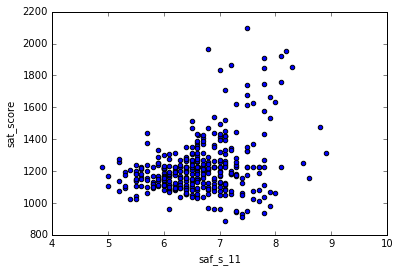

In [13]:
combined.plot.scatter('saf_s_11', 'sat_score')

* From the scatter plot, there is a trend as the saftey score gets higher, the sat score gets higher too. Which validates the high correlation score. 

In [52]:
dist_avg = combined.groupby('school_dist').mean()
safty_avg = dist_avg['saf_tot_11']

In [19]:
# Set up basemp for Mercator Projector
from mpl_toolkits.basemap import Basemap

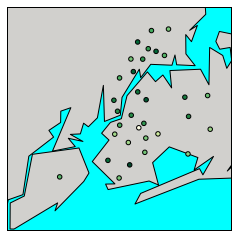

In [46]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')

m.drawcoastlines()
m.fillcontinents(color='#d1d0cd',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

longitude = dist_avg['lon'].tolist()
latitute = dist_avg['lat'].tolist()
m.scatter(longitude, latitute, latlon = True, c = safty_avg, zorder = 2, cmap = 'YlGn')

* School districts in Manhattan have higher saftey scores than other districts. Queens and Brooklyn have lower saftey scores. The Bronx and Staten Island are in between.  

# Plotting racial correlations

In [49]:
cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
racial_correlations = correlations[cols]

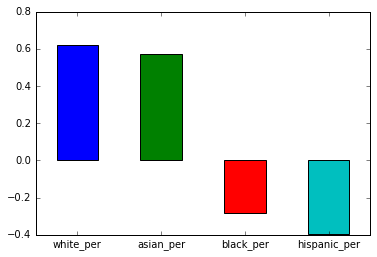

In [50]:
racial_correlations.plot.bar(rot = 0)

* Unsurprisingly, race does have a strong correlation in SAT scores. Asian and White kids have a much better SAT score than Black and Hispanic kids, which does imply that equality exists in different races using SAT score as a evaluation for college admissions. 

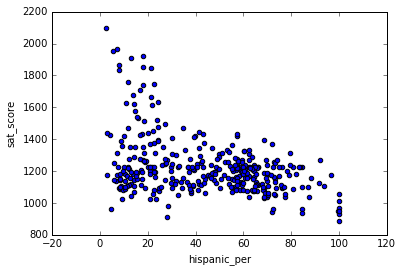

In [47]:
combined.plot.scatter('hispanic_per', 'sat_score')

* There is a clear trend that as the percentage of hispanic students rise, the SAT score lowers. 
* In the lower SAT score range (below 1200) though, hispanic percentage doesn't have a strong correlation with SAT score. 
* When hispanic percentage reaches 100, the SAT scores are all in the low range (below 1200)

In [58]:
low_hisp = combined[(combined['hispanic_per'] < 10) & (combined['sat_score']>1800)]
low_hisp['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

* All schools above are public magnet, science & tech specialized high school in NYC, evenly distributed in all 5 city districts. They admit students by their Specialized High Schools Admissions Test scores.

# Plotting gender correlations 

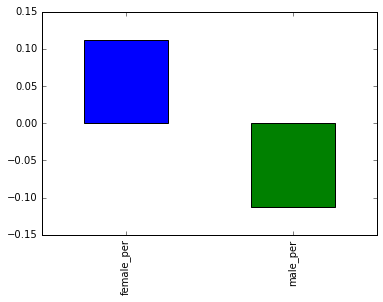

In [64]:
gender_corr = correlations[['female_per', 'male_per']]
gender_corr.plot.bar()

* There is a weak correlation between gender and SAT score, we can't tell if it's meaningful yet.

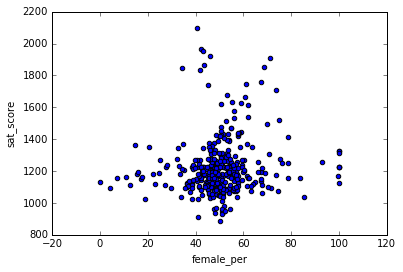

In [66]:
combined.plot.scatter('female_per', 'sat_score')

* Most schools have 40% - 60% female students, and most of them fall into the 1000 - 1400 SAT score range. 
* Schools with large percentage of only one gender in general have a lower SAT score.

In [67]:
high_fml = combined[(combined['female_per']>60) & (combined['sat_score'] > 1700)]
high_fml['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

* All of the schools above are public high schools that focuses on liberal arts. All of them are in Manhattan except for TOWNSEND HARRIS HIGH SCHOOL which is in Queens.

In [68]:
combined['ap_per'] = combined['AP Test Takers ']/ combined['total_enrollment']

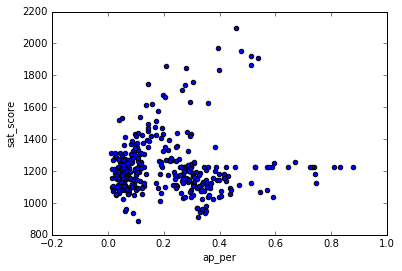

In [69]:
combined.plot.scatter('ap_per', 'sat_score')

* It looks like there isn't a very clear correlation between percentage of AP test takers in a school and SAT scores. Most 